<a href="https://colab.research.google.com/github/ducanhho2296/Masked-Face-Recognition-Challenge/blob/main/Arcface_Masked_face_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ResNet34 - Face recognition

github limit file size to upload model, so I upload the weights in google drive


In [ ]:
import gdown
!gdown 1LVB3CdVejpmGHM28BpqqkbZP5hDEcdZY

Downloading...
From: https://drive.google.com/uc?id=1LVB3CdVejpmGHM28BpqqkbZP5hDEcdZY
To: /content/arcface_weights.h5
100% 137M/137M [00:02<00:00, 48.9MB/s]


##Model Arcface-Resnet34

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.engine import training

def ResNet34():

	img_input = layers.Input(shape=(112, 112, 3))

	x = layers.ZeroPadding2D(padding=1, name='conv1_pad')(img_input)
	x = layers.Conv2D(64, 3, strides=1, use_bias=False, 
                   kernel_initializer='glorot_normal', 
                   name='conv1_conv')(x)
	x = layers.BatchNormalization(axis=3, epsilon=2e-5, momentum=0.9, name='conv1_bn')(x)
	x = layers.PReLU(shared_axes=[1, 2], name='conv1_prelu')(x)
	x = stack_fn(x)

	model = training.Model(img_input, x, name='ResNet34')

	return model

def block1(x, filters, kernel_size=3, stride=1, conv_shortcut=True, name=None):
	bn_axis = 3

	if conv_shortcut:
		shortcut = layers.Conv2D(filters, 1, strides=stride, use_bias=False, kernel_initializer='glorot_normal', name=name + '_0_conv')(x)
		shortcut = layers.BatchNormalization(axis=bn_axis, epsilon=2e-5, momentum=0.9, name=name + '_0_bn')(shortcut)
	else:
		shortcut = x

	x = layers.BatchNormalization(axis=bn_axis, epsilon=2e-5, momentum=0.9, name=name + '_1_bn')(x)
	x = layers.ZeroPadding2D(padding=1, name=name + '_1_pad')(x)
	x = layers.Conv2D(filters, 3, strides=1, kernel_initializer='glorot_normal', use_bias=False, name=name + '_1_conv')(x)
	x = layers.BatchNormalization(axis=bn_axis, epsilon=2e-5, momentum=0.9, name=name + '_2_bn')(x)
	x = layers.PReLU(shared_axes=[1, 2], name=name + '_1_prelu')(x)

	x = layers.ZeroPadding2D(padding=1, name=name + '_2_pad')(x)
	x = layers.Conv2D(filters, kernel_size, strides=stride, kernel_initializer='glorot_normal', use_bias=False, name=name + '_2_conv')(x)
	x = layers.BatchNormalization(axis=bn_axis, epsilon=2e-5, momentum=0.9, name=name + '_3_bn')(x)

	x = layers.Add(name=name + '_add')([shortcut, x])
	return x

def stack1(x, filters, blocks, stride1=2, name=None):
	x = block1(x, filters, stride=stride1, name=name + '_block1')
	for i in range(2, blocks + 1):
		x = block1(x, filters, conv_shortcut=False, name=name + '_block' + str(i))
	return x

def stack_fn(x):
	x = stack1(x, 64, 3, name='conv2')
	x = stack1(x, 128, 4, name='conv3')
	x = stack1(x, 256, 6, name='conv4')
	return stack1(x, 512, 3, name='conv5')

###Load model

In [ ]:
def loadModel(model_path):
	base_model = ResNet34()
	inputs = base_model.inputs[0]
	arcface_model = base_model.outputs[0]
	arcface_model = layers.BatchNormalization(momentum=0.9, epsilon=2e-5)(arcface_model)
	arcface_model = layers.Dropout(0.4)(arcface_model)
	arcface_model = layers.Flatten()(arcface_model)
	arcface_model = layers.Dense(512, activation=None, use_bias=True, kernel_initializer="glorot_normal")(arcface_model)
	embedding = layers.BatchNormalization(momentum=0.9, epsilon=2e-5, name="embedding", scale=True)(arcface_model)
	model = keras.models.Model(inputs, embedding, name=base_model.name)

	model.load_weights(model_path)

	return model

In [ ]:
model_path = "/content/arcface_weights.h5"
model = loadModel(model_path)

In [ ]:
model.summary() 

Model: "ResNet34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 112, 112, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 114, 114, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  1728        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

##Testset-preprocessing

###Loading image

In [ ]:
import os
import numpy as np
import pandas as pd
import cv2
import base64
from pathlib import Path
from PIL import Image
import requests
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, save_img, img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.preprocessing import image



def load_image(img):
	exact_image = False; base64_img = False; url_img = False

	if type(img).__module__ == np.__name__:
		exact_image = True

	elif len(img) > 11 and img[0:11] == "data:image/":
		base64_img = True

	elif len(img) > 11 and img.startswith("http"):
		url_img = True

	#---------------------------

	if base64_img == True:
		img = loadBase64Img(img)

	elif url_img:
		img = np.array(Image.open(requests.get(img, stream=True).raw).convert('RGB'))

	elif exact_image != True: #image path passed as input
		if os.path.isfile(img) != True:
			raise ValueError("Confirm that ",img," exists")

		img = cv2.imread(img)

	return img


def preprocess_img(img, target_size=(112, 112), 
                   grayscale=False,
                   enforce_detection=True,
                   detector_backend='retinaface',
                   return_region=False,
                   align=True):
  img = load_image(img)
  base_img = img.copy()

  # img, region = detect_face(img = img,
  #                           detector_backend = detector_backend, 
  #                           grayscale = grayscale, 
  #                           enforce_detection = enforce_detection, 
  #                           align = align)

	#--------------------------

  if img.shape[0] == 0 or img.shape[1] == 0:
    if enforce_detection == True:
      raise ValueError("Detected face shape is ", img.shape,
                    ". Consider to set enforce_detection argument to False.")
    else: #restore base image
      img = base_img.copy()

	#--------------------------

	#post-processing
  if grayscale == True:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

	#---------------------------------------------------
	#resize image to expected shape


  if img.shape[0] > 0 and img.shape[1] > 0:
    factor_0 = target_size[0] / img.shape[0]
    factor_1 = target_size[1] / img.shape[1]
    factor = min(factor_0, factor_1)

    dsize = (int(img.shape[1] * factor), int(img.shape[0] * factor))
    img = cv2.resize(img, dsize)

    # Then pad the other side to the target size by adding black pixels
    diff_0 = target_size[0] - img.shape[0]
    diff_1 = target_size[1] - img.shape[1]
    if grayscale == False:
			# Put the base image in the middle of the padded image
      img = np.pad(img, ((diff_0 // 2, diff_0 - diff_0 // 2), 
                      (diff_1 // 2, diff_1 - diff_1 // 2), (0, 0)), 'constant')
    else:
      img = np.pad(img, ((diff_0 // 2, diff_0 - diff_0 // 2), 
                      (diff_1 // 2, diff_1 - diff_1 // 2)), 'constant')

	#------------------------------------------

	#double check: if target image is not still the same size with target.
  if img.shape[0:2] != target_size:
    img = cv2.resize(img, target_size)

	#---------------------------------------------------

	#normalizing the image pixels

  img_pixels = image.img_to_array(img) #what this line doing? must?
  img_pixels = np.expand_dims(img_pixels, axis = 0)
  img_pixels /= 255 #normalize input in [0, 1]

	#-------------------------------------------------

	# if return_region == True:
	# 	return img_pixels, region
	# else:
  return img_pixels

def forward_image(img_path):
  
  img = preprocess_img(img_path, target_size=(112, 112))
  return img

Next: Create threshold Dmax = 0.35, if sim < Dmax => same person. If Dmax < sim < 0.7 => using LBP eyebrows. distance outside this bound will not be considered

###Cosine distance

In [ ]:
def findCosineDistance(source_representation, test_representation):
    a = np.matmul(np.transpose(source_representation), test_representation)
    b = np.sum(np.multiply(source_representation, source_representation))
    c = np.sum(np.multiply(test_representation, test_representation))
    dist = 1 - (a / (np.sqrt(b) * np.sqrt(c)))
    print("cosine similarity: ", dist)
    #similarity threshold
    if dist >= 0 and dist < 0.35: print("Same person")
    elif dist >= 0.35 and dist < 0.7: print("Must use LBP to verify this pair")
    else: print("not the same person")
    return dist


##**Test model with test images**

In [ ]:
img1_path = "/content/15.PNG"
img2_path = "/content/12.png"
img3_path = "image (2).jpg" 

test load images with ImageDataGenerator()

In [ ]:
# datagen = ImageDataGenerator(rescale=1.0/255.0)
# test_data = datagen.flow_from_directory('/content/', target_size=(112,112))
# img_embedding = model.predict(test_data)
# img_embedding.shape

In [ ]:
img1_embedding = model.predict(forward_image(img1_path))[0]
img2_embedding = model.predict(forward_image(img2_path))[0]
# img3_embedding = model.predict(img3)[0]

####Plot images and do verifying task

cosine similarity:  0.018607616424560547
Same person


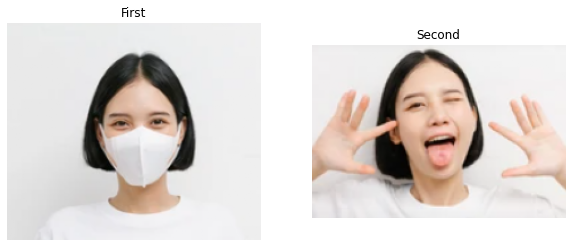

In [ ]:
import matplotlib.pyplot as plt
img1 = plt.imread(img1_path)
img2 = plt.imread(img2_path)
fig = plt.figure(figsize=(10, 10))

rows = 2
columns = 2
fig.add_subplot(rows, columns, 1)

# showing image
plt.imshow(img1)
plt.axis('off')
plt.title("First")
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(img2)
plt.axis('off')
plt.title("Second")

# Verify person with Cosine distance
dist_emb = findCosineDistance(img1_embedding, img2_embedding)

------------------------------------------------------------------------

_____________________________________________________________________________

#another resnet34 model
This pretrained model came from insigntface, which required inputs as a tensor 

In [ ]:
!wget https://github.com/leondgarse/Keras_insightface/releases/download/v1.0.0/resnet34_MXNET_E_SGD_REG_1e3_on_batch_true_lr1e1_random0_arc_S32_E1_BS512_casia_basic_agedb_30_epoch_36_0.949500.h5

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
model_34 = keras.models.load_model("resnet34.h5", compile=False)
# model_34.summary()

In [ ]:
# validation_dir = "/content/test/"
# IMG_SIZE = (112, 112)
# BATCH_SIZE = 1
# validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
#                                                                  shuffle=False,
#                                                                  batch_size=BATCH_SIZE,
#                                                                  image_size=IMG_SIZE)
#-----------------------------------------------------------------------------------------#
datagen = ImageDataGenerator(rescale=1.0/255.0)
test_data = datagen.flow_from_directory('/content/test', target_size=(112,112))

Found 2 images belonging to 2 classes.


In [ ]:
emb = []
emb = model.predict(test_data)
# emb2 = model_34.predict(img2)

cosine similarity:  0.9668694548308849
not the same person


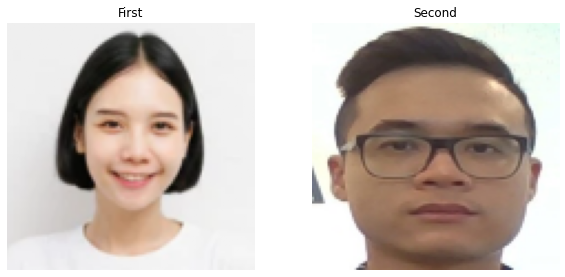

In [ ]:
import matplotlib.pyplot as plt
img1 = plt.imread("/content/test/0/14_resize.PNG")
img2 = plt.imread("/content/test/0/image_resize.jpg")
fig = plt.figure(figsize=(10, 10))

rows = 2
columns = 2
fig.add_subplot(rows, columns, 1)

# showing image
plt.imshow(img1)
plt.axis('off')
plt.title("First")
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(img2)
plt.axis('off')
plt.title("Second")

# Verify person with Cosine distance
dist_emb_test = findCosineDistance(emb[0], emb[1])